In [ ]:
!pip -q install pandas numpy scikit-learn sentence-transformers hdbscan umap-learn matplotlib tqdm #installing core libraries
from google.colab import drive
drive.mount("/content/drive")
import os
OUT_DIR = "/content/drive/MyDrive"   #mounting a drive
os.makedirs(OUT_DIR, exist_ok=True)
print("OUT_DIR:", OUT_DIR)
META_PATH = "/content/meta_Electronics_60k_clean.jsonl"
print("META_PATH:", META_PATH)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 120.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 8.8 MB/s eta 0:00:00
Mounted at /content/drive
OUT_DIR: /content/drive/MyDrive
META_PATH: /content/meta_Electronics_60k_clean.jsonl


In [ ]:
import os
import re         #importing and ml toolkit
import json
import gzip
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import umap
import hdbscan
from sentence_transformers import SentenceTransformer

In [ ]:
META_PATH = "/content/meta_Electronics_60k.jsonl"

with open(META_PATH, "r", encoding="utf-8") as f:
    first = f.readline().strip()

print(first[:200])


{"category": ["Electronics", "Computers & Accessories", "Tablet Accessories", "Bags, Cases & Sleeves", "Cases"], "tech1": " class=\"a-keyvalue prodDetTable\" role=\"presentation\">\n         \n       


JSON reader that parses records , supports linmits.

In [ ]:
def read_jsonlines_skip_bad(path, limit=None):
    rows = []
    bad = 0
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for i, line in enumerate(tqdm(f, desc=f"Reading {path}")):
            if limit is not None and len(rows) >= limit:
                break
            s = line.strip()
            if not s:
                continue
            try:
                rows.append(json.loads(s))
            except json.JSONDecodeError:
                bad += 1
                if bad <= 3:
                    print(f"Skipping bad line {i+1}: {s[:120]}")
                continue
    print("Loaded rows:", len(rows), "Bad lines skipped:", bad)
    return pd.DataFrame(rows)

df_meta = read_jsonlines_skip_bad(META_PATH, limit=None)
print("df_meta shape:", df_meta.shape)
df_meta.head(3)


Reading /content/meta_Electronics_60k.jsonl: 13327it [00:00, 13890.85it/s]


Skipping bad line 13327: {"category": ["Electronics", "Computers & Accessories", "Data Storage", "USB Flash Drives"], "tech1": "", "description":
Loaded rows: 13326 Bad lines skipped: 1
df_meta shape: (13326, 19)


,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,"[Electronics, Computers & Accessories, Tablet ...","class=""a-keyvalue prodDetTable"" role=""present...","[<b>TSMINE, JUST FOR YOU!</b> <br> <br> This T...",,Tsmine Samsung Galaxy Tab 2 7.0-inch GT-P3113 ...,[B0047EM82I],,Tsmine,[Specially designed for Samsung Galaxy Tab 2 7...,"[>#16,570 in Computers & Accessories > Tablet ...","[B01FYK86U6, B07346QZ42, B01JU7ZJW2, B01FYK859...",{},Cell Phones & Accessories,"class=""a-bordered a-horizontal-stripes a-spa...","September 21, 2015",$1.96,B015MQ4LLU,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
1,"[Electronics, Headphones]",,"[Compatible with LG Xenon GR500, GR700 (Vu Plu...",,Premium Stereo Headset Hands-free for LG Xenon...,[],,MyNetDeals,[Brand New High Quality MyBat Handsfree Headse...,"[>#1,936,157 in Cell Phones & Accessories (See...",[],{},Cell Phones & Accessories,,,,B0035CTQ64,[],[]
2,"[Electronics, eBook Readers &amp; Accessories,...",,[A zesty tale. (Publishers Weekly)<br /><br />...,,One Hot Summer,"[0425167798, 039914157X]",,Visit Amazon's Carolina Garcia Aguilera Page,[],"3,105,177 in Books (",[],NaN,Books,,,$11.49,0060009810,[],[]


# **Explatory data analysis**

In [ ]:
print(df_meta.columns.tolist())
df_meta.sample(3, random_state=42)


['category', 'tech1', 'description', 'fit', 'title', 'also_buy', 'tech2', 'brand', 'feature', 'rank', 'also_view', 'details', 'main_cat', 'similar_item', 'date', 'price', 'asin', 'imageURL', 'imageURLHighRes']


,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
8872,"[Electronics, Computers & Accessories, Compute...",,[],,Bluecell (LEN-023) Semi-Transparent Silicone K...,[],,BLUECELL,[],"[>#14,729 in Computers & Accessories > Compute...",[],{},Computers,,"April 13, 2013",,B00B43OPBC,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
5046,"[Electronics, Computers & Accessories, Tablet ...","class=""a-keyvalue prodDetTable"" role=""present...",[<b>This case is for the Samsung Galaxy Tab 4 ...,,Fintie Samsung Galaxy Tab 4 10.1 (10-Inch) Sma...,[],"class=""a-keyvalue prodDetTable"" role=""present...",Fintie,[Specifically designed for Samsung Galaxy Tab ...,"[>#100,167 in Computers & Accessories > Tablet...",[],{},Computers,,"July 10, 2014",,B00LO12WXW,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
11272,"[Electronics, Portable Audio & Video, CB & Two...",,[2 pack of BATT6R Midland batteries for Midlan...,,Midland Radio - Pair Of Rechargeable Batteries...,[],,Original Equipment Manufacture,[],"1,745,413 in Health & Household (",[],{'ASIN: ': 'B00QXLP1DQ'},Health & Personal Care,,,,B00QXLP1DQ,[],[]


In [ ]:
missing = df_meta.isna().sum().sort_values(ascending=False)
(missing / len(df_meta) * 100).round(2).head(20) #calcualting the missing value


,0
details,0.53
tech1,0.00
category,0.00
description,0.00
fit,0.00
also_buy,0.00
title,0.00
brand,0.00
feature,0.00
rank,0.00


In [ ]:
import numpy as np
import re

def clean_text(x):   #clean text function to remove htlml,whitespacesetc
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return ""
    if isinstance(x, list):
        x = " ".join([str(i) for i in x if i is not None])
    x = str(x).lower()
    x = re.sub(r"<.*?>", " ", x)       # removing html tags
    x = re.sub(r"\s+", " ", x).strip()
    return x

CSS_HINTS = ["{", "}", ".a-", "#aloha", "background", "box-shadow", "sprite", "popover", "amazonui", "display:none"]

def looks_like_css_or_html(s: str) -> bool:
    s_low = s.lower()
    if len(s_low) > 200 and any(h in s_low for h in CSS_HINTS):
        return True
    if "<" in s_low and ">" in s_low and len(s_low) > 200:
        return True
    return False

def parse_price_clean(x):
    if x is None:
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)

    s = str(x).strip()
    if not s:
        return np.nan
    if looks_like_css_or_html(s):
        return np.nan

    s_low = s.lower()
    if any(tok in s_low for tok in ["see price", "unavailable", "currently unavailable", "add to cart"]):
        return np.nan

    nums = re.findall(r"\d+(?:\.\d+)?", s.replace(",", ""))
    if not nums:
        return np.nan

    vals = [float(n) for n in nums]
    return min(vals)


renaming key columns,standardizing IDS and creating cleaned text fields

In [ ]:
keep_cols = ["asin", "title", "brand", "main_cat", "category", "feature", "description", "price"]
for c in keep_cols:
    if c not in df_meta.columns:
        df_meta[c] = None

df_all = df_meta[keep_cols].copy()

df_all["asin"] = df_all["asin"].astype(str).str.strip()
df_all["title_clean"] = df_all["title"].apply(clean_text)
df_all["brand_clean"] = df_all["brand"].fillna("unknown").apply(clean_text)
df_all["maincat_clean"] = df_all["main_cat"].apply(clean_text)
df_all["category_clean"] = df_all["category"].apply(clean_text)
df_all["feature_clean"] = df_all["feature"].apply(clean_text)
df_all["desc_clean"] = df_all["description"].apply(clean_text)

df_all["price_raw"] = df_meta["price"].astype(str)
df_all["price"] = df_meta["price"].apply(parse_price_clean)

# minimal filtering
df_all = df_all[(df_all["title_clean"].str.len() > 0) & (df_all["asin"].str.len() > 0)].reset_index(drop=True)

print("df_all rows:", len(df_all))
print("Parsed price %:", (df_all["price"].notna().mean()*100))
df_all.head(3)


df_all rows: 13326
Parsed price %: 38.52618940417229


,asin,title,brand,main_cat,category,feature,description,price,title_clean,brand_clean,maincat_clean,category_clean,feature_clean,desc_clean,price_raw
0,B015MQ4LLU,Tsmine Samsung Galaxy Tab 2 7.0-inch GT-P3113 ...,Tsmine,Cell Phones & Accessories,"[Electronics, Computers & Accessories, Tablet ...",[Specially designed for Samsung Galaxy Tab 2 7...,"[<b>TSMINE, JUST FOR YOU!</b> <br> <br> This T...",1.96,tsmine samsung galaxy tab 2 7.0-inch gt-p3113 ...,tsmine,cell phones & accessories,electronics computers & accessories tablet acc...,specially designed for samsung galaxy tab 2 7....,"tsmine, just for you! this tsmine cartoon peng...",$1.96
1,B0035CTQ64,Premium Stereo Headset Hands-free for LG Xenon...,MyNetDeals,Cell Phones & Accessories,"[Electronics, Headphones]",[Brand New High Quality MyBat Handsfree Headse...,"[Compatible with LG Xenon GR500, GR700 (Vu Plu...",NaN,premium stereo headset hands-free for lg xenon...,mynetdeals,cell phones & accessories,electronics headphones,brand new high quality mybat handsfree headset...,"compatible with lg xenon gr500, gr700 (vu plus...",
2,0060009810,One Hot Summer,Visit Amazon's Carolina Garcia Aguilera Page,Books,"[Electronics, eBook Readers &amp; Accessories,...",[],[A zesty tale. (Publishers Weekly)<br /><br />...,11.49,one hot summer,visit amazon's carolina garcia aguilera page,books,electronics ebook readers &amp; accessories eb...,,a zesty tale. (publishers weekly) garcia aguil...,$11.49


Noise reduction: applying heuristic keywordsfliters to reduce noise that might destroy the cluters.

In [ ]:
ACCESSORY_WORDS = [
    "case","cover","screen protector","protector","cable","charger","adapter","replacement",
    "strap","mount","holder","stand","skin","wallet","stylus","battery","bag","sleeve","pouch"
]
pattern = "|".join([re.escape(w) for w in ACCESSORY_WORDS])

df_priced_main = df_priced[~df_priced["title_clean"].str.contains(pattern, regex=True)].copy()
print("df_priced_main rows:", len(df_priced_main))


df_priced_main rows: 1737


Plotting the the top categories

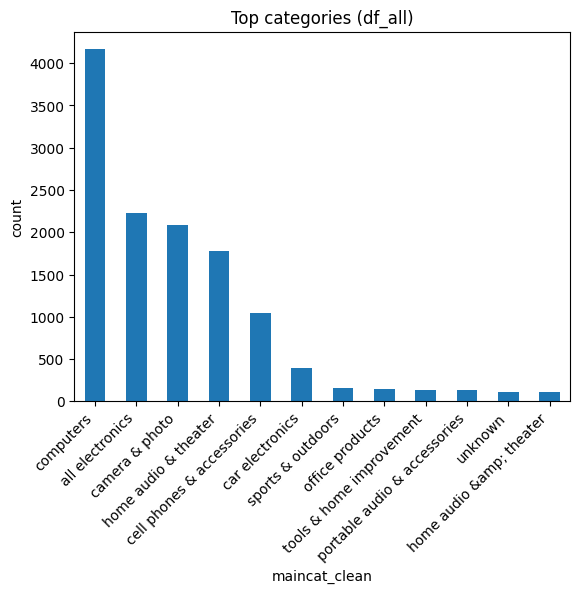

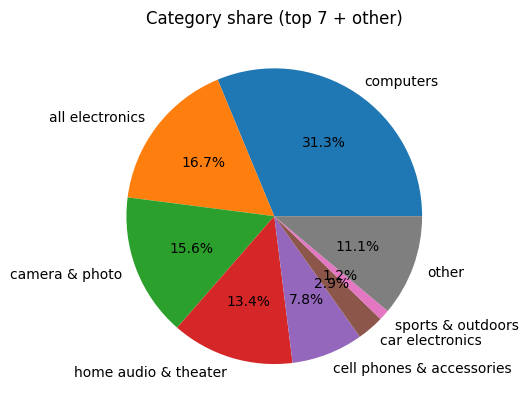

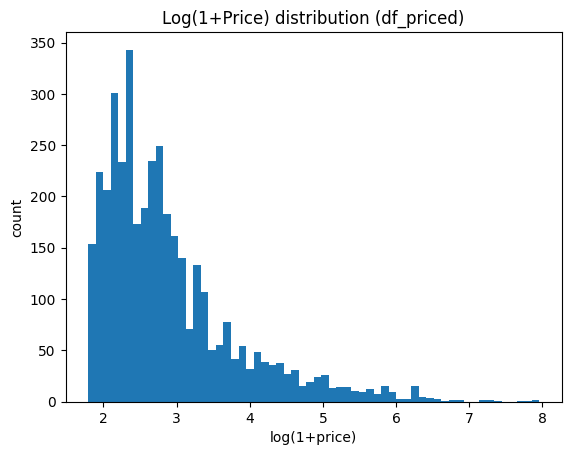

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Categories on full dataset
cat_col = "maincat_clean" if df_all["maincat_clean"].str.len().sum() > 0 else "category_clean"
cats = df_all[cat_col].replace("", "unknown")

top = cats.value_counts().head(12)
plt.figure()
top.plot(kind="bar")
plt.title("Top categories (df_all)")
plt.ylabel("count")
plt.xticks(rotation=45, ha="right")
plt.show()

counts = cats.value_counts()
top_n = 7
pie_counts = pd.concat([counts.head(top_n), pd.Series({"other": counts.iloc[top_n:].sum()})])
plt.figure()
pie_counts.plot(kind="pie", autopct="%1.1f%%")
plt.title(f"Category share (top {top_n} + other)")
plt.ylabel("")
plt.show()

# Price distribution (priced subset)
plt.figure()
plt.hist(np.log1p(df_priced["price"]), bins=60)
plt.title("Log(1+Price) distribution (df_priced)")
plt.xlabel("log(1+price)")
plt.ylabel("count")
plt.show()


Feature eng for embeddings-concatinating cleaned fields and adding lightweight numeric signals.

In [ ]:
# Building text for embedding
df_all["text_for_embed"] = (
    df_all["title_clean"] + " " +
    df_all["brand_clean"] + " " +
    df_all["maincat_clean"] + " " +
    df_all["category_clean"] + " " +
    df_all["feature_clean"] + " " +
    df_all["desc_clean"]
).str.strip()

df_all["brand_freq"] = df_all["brand_clean"].map(df_all["brand_clean"].value_counts(normalize=True)).fillna(0)
df_all["text_len"] = df_all["text_for_embed"].str.len().fillna(0)


encodeing products into dense vectors with batching and caching

In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer
E_PATH = os.path.join(OUT_DIR, "E_all.npy")
if os.path.exists(E_PATH):
    E = np.load(E_PATH)
    print("Loaded E:", E.shape)
else:
    embedder = SentenceTransformer("all-MiniLM-L6-v2")
    E = embedder.encode(
        df_all["text_for_embed"].tolist(),
        batch_size=128,
        show_progress_bar=True,
        normalize_embeddings=True
    )
    np.save(E_PATH, E)
    print("Saved E:", E.shape, "->", E_PATH)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/105 [00:00<?, ?it/s]

Saved E: (13326, 384) -> /content/drive/MyDrive/E_all.npy


# **KMeans**
combining embeddings with scaled numeric features and running Kmeans acrossa range of K nd tracking silhouette score for the selection of the best K


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Create X = [embeddings + numeric]
from sklearn.preprocessing import StandardScaler
N = StandardScaler().fit_transform(df_all[["brand_freq","text_len"]].values)
X = np.hstack([E, N])
print("X shape:", X.shape)

Ks = [10, 15, 20, 30, 40, 60]
k_results = []

# sample for silhouette (fast)
rng = np.random.default_rng(42)
idx = rng.choice(X.shape[0], size=min(6000, X.shape[0]), replace=False)

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_km = km.fit_predict(X)

    sil = silhouette_score(X[idx], labels_km[idx])      # sampled silhouette
    dbi = davies_bouldin_score(X[idx], labels_km[idx])  # sampled DB for speed

    k_results.append((k, sil, dbi))
    print("done K=", k, "sil=", sil, "db=", dbi)

k_results


X shape: (13326, 386)
done K= 10 sil= 0.10969335963907122 db= 1.835490570216475
done K= 15 sil= 0.07444219001172823 db= 2.3537195124243926
done K= 20 sil= 0.06896087801987995 db= 2.4956437360181836
done K= 30 sil= 0.06709114549269753 db= 2.6093790542376962
done K= 40 sil= 0.061628357935038784 db= 2.7015663631690052
done K= 60 sil= 0.057525872304142266 db= 2.7504400590696787


[(10, np.float64(0.10969335963907122), np.float64(1.835490570216475)),
 (15, np.float64(0.07444219001172823), np.float64(2.3537195124243926)),
 (20, np.float64(0.06896087801987995), np.float64(2.4956437360181836)),
 (30, np.float64(0.06709114549269753), np.float64(2.6093790542376962)),
 (40, np.float64(0.061628357935038784), np.float64(2.7015663631690052)),
 (60, np.float64(0.057525872304142266), np.float64(2.7504400590696787))]

Selecting the best Kand plotting the silhouette scores over the k rnge

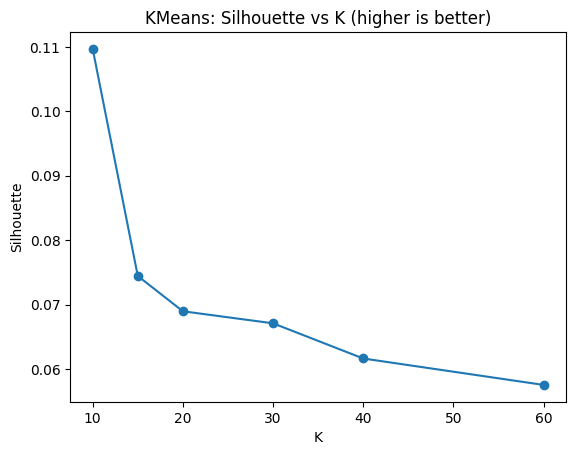

Selected K: 10
KMeans silhouette: 0.10948089836606971 DB: 1.8405866381212381


In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot([r[0] for r in k_results], [r[1] for r in k_results], marker="o")
plt.title("KMeans: Silhouette vs K (higher is better)")
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.show()

best_k = max(k_results, key=lambda t: t[1])[0]
print("Selected K:", best_k)

km = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
labels_km = km.fit_predict(X)

sil_km = silhouette_score(X, labels_km)
db_km  = davies_bouldin_score(X, labels_km)
print("KMeans silhouette:", sil_km, "DB:", db_km)

KMeans fitting.

In [ ]:
best_k = max(k_results, key=lambda t: t[1])[0]
print("Best K by silhouette:", best_k)

km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_km = km.fit_predict(X)


Best K by silhouette: 10


UMAP for dimensionality reduction

In [ ]:
import umap
import hdbscan
import pandas as pd

U10_PATH = os.path.join(OUT_DIR, "U10_all.npy")

if os.path.exists(U10_PATH):
    U10 = np.load(U10_PATH)
    print("Loaded U10:", U10.shape)
else:
    reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=10, metric="cosine", random_state=42)
    U10 = reducer.fit_transform(E)
    np.save(U10_PATH, U10)
    print("Saved U10:", U10.shape, "->", U10_PATH)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved U10: (13326, 10) -> /content/drive/MyDrive/U10_all.npy


Evaluating HDBSCAN ove a hyperparameter grid and computing non-noise and silhouette.

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

def eval_labels_fast(X_small, labels, sample_size=6000, seed=42):
    mask = labels != -1
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_rate = float((labels == -1).mean())

    sil = None
    dbi = None
    if mask.sum() > 500 and n_clusters > 1:
        idx = np.where(mask)[0]
        rng = np.random.default_rng(seed)
        if len(idx) > sample_size:
            idx = rng.choice(idx, size=sample_size, replace=False)
        sil = silhouette_score(X_small[idx], labels[idx])
        dbi = davies_bouldin_score(X_small[idx], labels[idx])
    return n_clusters, noise_rate, sil, dbi

mcs_list = [20, 30, 50, 80]
ms_list  = [5, 10, 15]

grid = []
total = len(mcs_list) * len(ms_list)
step = 0

for mcs in mcs_list:
    for ms in ms_list:
        step += 1
        print(f"[{step}/{total}] HDBSCAN(mcs={mcs}, ms={ms})", flush=True)
        hd = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=ms)
        labels = hd.fit_predict(U10)
        n_clusters, noise_rate, sil, dbi = eval_labels_fast(U10, labels, sample_size=6000)
        grid.append((mcs, ms, n_clusters, noise_rate, sil, dbi))
        print("   clusters=", n_clusters, "noise=", round(noise_rate,3), "sil=", sil, "db=", dbi, flush=True)

grid_df = pd.DataFrame(grid, columns=["min_cluster_size","min_samples","n_clusters","noise_rate","silhouette","db_index"])
grid_df.to_csv(os.path.join(OUT_DIR, "hdbscan_grid_all.csv"), index=False)
grid_df.sort_values(["silhouette","noise_rate"], ascending=[False, True]).head(10)


[1/12] HDBSCAN(mcs=20, ms=5)
   clusters= 130 noise= 0.204 sil= 0.601094 db= 0.5258216410573827
[2/12] HDBSCAN(mcs=20, ms=10)
   clusters= 114 noise= 0.201 sil= 0.63106 db= 0.4683175189441482
[3/12] HDBSCAN(mcs=20, ms=15)
   clusters= 104 noise= 0.204 sil= 0.6445713 db= 0.43750265927784693
[4/12] HDBSCAN(mcs=30, ms=5)
   clusters= 94 noise= 0.19 sil= 0.6093302 db= 0.5286193099710317
[5/12] HDBSCAN(mcs=30, ms=10)
   clusters= 83 noise= 0.167 sil= 0.5873033 db= 0.5120335740315948
[6/12] HDBSCAN(mcs=30, ms=15)
   clusters= 78 noise= 0.167 sil= 0.59339476 db= 0.4978769184024031
[7/12] HDBSCAN(mcs=50, ms=5)
   clusters= 62 noise= 0.163 sil= 0.62261516 db= 0.5110557209949204
[8/12] HDBSCAN(mcs=50, ms=10)
   clusters= 57 noise= 0.127 sil= 0.59626204 db= 0.5208712752706726
[9/12] HDBSCAN(mcs=50, ms=15)
   clusters= 57 noise= 0.143 sil= 0.586193 db= 0.5295873407657491
[10/12] HDBSCAN(mcs=80, ms=5)
   clusters= 47 noise= 0.112 sil= 0.6094269 db= 0.5123745559833813
[11/12] HDBSCAN(mcs=80, ms=10)


,min_cluster_size,min_samples,n_clusters,noise_rate,silhouette,db_index
2,20,15,104,0.203737,0.644571,0.437503
1,20,10,114,0.201111,0.631060,0.468318
6,50,5,62,0.162539,0.622615,0.511056
9,80,5,47,0.112037,0.609427,0.512375
3,30,5,94,0.190080,0.609330,0.528619
0,20,5,130,0.203887,0.601094,0.525822
7,50,10,57,0.127195,0.596262,0.520871
5,30,15,78,0.167117,0.593395,0.497877
4,30,10,83,0.166742,0.587303,0.512034
8,50,15,57,0.143404,0.586193,0.529587


Fitting HDBSCAN

In [ ]:
best = grid_df.sort_values(["silhouette","noise_rate"], ascending=[False, True]).iloc[0]
best_mcs = int(best["min_cluster_size"])
best_ms  = int(best["min_samples"])
print("Chosen HDBSCAN params:", best_mcs, best_ms)

hd = hdbscan.HDBSCAN(min_cluster_size=best_mcs, min_samples=best_ms)
labels_hd = hd.fit_predict(U10)

np.save(os.path.join(OUT_DIR, "labels_hdbscan_all.npy"), labels_hd)

n_clusters = len(set(labels_hd)) - (1 if -1 in labels_hd else 0)
noise_rate = float((labels_hd == -1).mean())
print("HDBSCAN clusters:", n_clusters, "noise:", noise_rate)


Chosen HDBSCAN params: 20 15
HDBSCAN clusters: 104 noise: 0.20373705538045925


Visualizing the cluster sizes

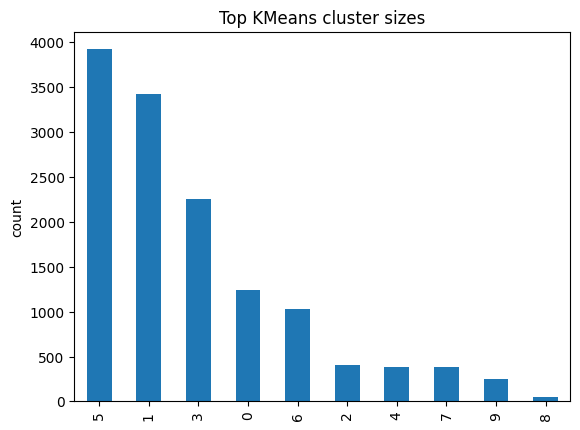

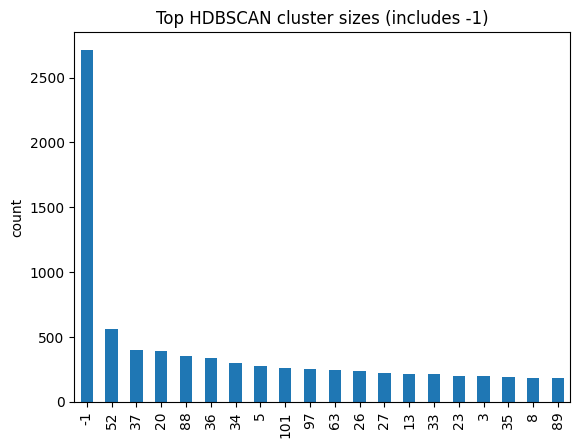

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

U2_PATH = os.path.join(OUT_DIR, "U2_all.npy")

if os.path.exists(U2_PATH):
    U2 = np.load(U2_PATH)
else:
    U2 = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, metric="cosine", random_state=42).fit_transform(E)
    np.save(U2_PATH, U2)



km_sizes = pd.Series(labels_km).value_counts().sort_values(ascending=False)
hd_sizes = pd.Series(labels_hd).value_counts().sort_values(ascending=False)

plt.figure()
km_sizes.head(20).plot(kind="bar")
plt.title("Top KMeans cluster sizes")
plt.ylabel("count")
plt.show()

plt.figure()
hd_sizes.head(20).plot(kind="bar")
plt.title("Top HDBSCAN cluster sizes (includes -1)")
plt.ylabel("count")
plt.show()


Evaluating cluster median predictor

In [ ]:
import numpy as np

df_out = df_all.copy()
df_out["km_cluster"] = labels_km
df_out["hd_cluster"] = labels_hd

df_eval = df_out.dropna(subset=["price"]).copy()
df_eval = df_eval[(df_eval["price"] >= 5) & (df_eval["price"] <= 3000)].copy()

def cluster_median_mae(df_in, label_col, drop_noise=False, min_priced_per_cluster=20):
    d = df_in.copy()
    if drop_noise:
        d = d[d[label_col] != -1].copy()

    counts = d[label_col].value_counts()
    good = counts[counts >= min_priced_per_cluster].index
    d = d[d[label_col].isin(good)].copy()

    med = d.groupby(label_col)["price"].median()
    pred = d[label_col].map(med)
    mae = float(np.mean(np.abs(d["price"] - pred)))
    return mae, len(d), len(good)

mae_km, n_km, c_km = cluster_median_mae(df_eval, "km_cluster", drop_noise=False)
mae_hd, n_hd, c_hd = cluster_median_mae(df_eval, "hd_cluster", drop_noise=True)

print("KMeans median-price MAE:", mae_km, "priced rows used:", n_km, "clusters:", c_km)
print("HDBSCAN median-price MAE:", mae_hd, "priced rows used:", n_hd, "clusters:", c_hd)


KMeans median-price MAE: 28.944216804979252 priced rows used: 3856 clusters: 9
HDBSCAN median-price MAE: 22.459474723538705 priced rows used: 2532 clusters: 47


IQR- to measure how coherrent the clusters are

In [ ]:
def avg_cluster_iqr(df_in, label_col, drop_noise=False, min_priced_per_cluster=20):
    d = df_in.copy()
    if drop_noise:
        d = d[d[label_col] != -1].copy()

    counts = d[label_col].value_counts()
    good = counts[counts >= min_priced_per_cluster].index
    d = d[d[label_col].isin(good)].copy()

    q = d.groupby(label_col)["price"].quantile([0.25, 0.75]).unstack()
    q["iqr"] = q[0.75] - q[0.25]
    return float(q["iqr"].mean()), q.sort_values("iqr").head(10), q.sort_values("iqr", ascending=False).head(10)

iqr_km, best_km, worst_km = avg_cluster_iqr(df_eval, "km_cluster", drop_noise=False)
iqr_hd, best_hd, worst_hd = avg_cluster_iqr(df_eval, "hd_cluster", drop_noise=True)

print("Avg price IQR (KMeans):", iqr_km)
print("Avg price IQR (HDBSCAN non-noise):", iqr_hd)

best_hd, worst_hd


Avg price IQR (KMeans): 25.88111111111111
Avg price IQR (HDBSCAN non-noise): 22.591861702127655


(               0.25     0.75     iqr
 hd_cluster                          
 44          14.9600  14.9900  0.0300
 31           6.9100   8.9100  2.0000
 10           5.4050   9.5525  4.1475
 52           7.9500  12.9800  5.0300
 103          6.5900  11.8400  5.2500
 9           14.2475  19.5975  5.3500
 27           7.9000  13.4900  5.5900
 100          7.5400  13.2900  5.7500
 101          6.9825  12.7650  5.7825
 71          10.9900  16.9450  5.9550,
                0.25      0.75       iqr
 hd_cluster                             
 11          20.1800  191.9500  171.7700
 94           9.3600  117.7425  108.3825
 17          19.4125  116.3450   96.9325
 89          18.8000   82.9900   64.1900
 97           9.9500   62.7950   52.8450
 0           14.5275   65.8175   51.2900
 72           8.2800   56.8300   48.5500
 33           9.1050   43.8900   34.7850
 61          15.4700   43.9700   28.5000
 88           7.9350   34.3400   26.4050)

If we observe the cluster HDBSCAN has done a decent job clustering the components,all the ear peices,earphones and headphones are clustered in cluster52,the ipad accessories in cluster 37,and samsung accesoris in cluster 88


In [ ]:
# top HDBSCAN clusters (excluding noise)
top_clusters = [c for c in df_out["hd_cluster"].value_counts().index.tolist() if c != -1][:5]

for c in top_clusters:
    sub = df_out[df_out["hd_cluster"] == c].copy()
    priced_sub = sub.dropna(subset=["price"]).sort_values("price")
    print("\n====================")
    print("Cluster:", c, "total:", len(sub), "priced:", len(priced_sub))
    display(priced_sub[["title_clean","brand_clean","price"]].head(12))



Cluster: 52 total: 560 priced: 158


,title_clean,brand_clean,price
8055,pyle in ear back electret microphone-professio...,pyle,0.95
10683,ear hook loop clip replacement. bluetooth repa...,generic,1.23
10828,al60 transcription aluminum headset,al60,1.54
8323,koss sb40 computer headset with microphone,koss,1.54
10967,onanoff lovebuds high-definition earbud w magn...,onanoff,1.86
1958,"wireless bluetooth headphones, istoyo bt4.1 wa...",istoyo,1.96
354,qc15 / qc2 / qc25 memory foam replacement ear ...,senitek,1.96
1014,vowsvows 3.5mm earphones/earbuds/headphones st...,vowsvows,1.96
12914,vowsvows 3.5mm earphones/earbuds/headphones st...,vowsvows,1.96
8609,the ultimate i-kool freeze series headphone wi...,i-kool,1.96



Cluster: 37 total: 397 priced: 107


,title_clean,brand_clean,price
4422,tcd for apple ipad pro 12.9 inch [only] with r...,the case doctor get your case lift with the ca...,1.96
12900,"ipad enclosure, hidden &quot;home&quot; button...",displays2go,2.54
9564,vilesto ipad mini 2 / ipad mini 3 case black s...,vilesto,3.99
3252,tech &amp; go ipad bump case for ipad 2 and ne...,tech & go,4.95
7523,wellspring gift remarkable owl cleaner for iph...,wellspring,4.95
12173,"ipad pro 9.7 inch case, cambond slim fit auto ...",cambond,4.99
404,case for apple ipad air 2 - leafbook for ipad ...,leafbook,5.59
6771,ipad 2 accessory bundle including 1 rotating f...,eco-fused,6.42
4402,"asmyna unique protective case for ipad mini, (...",asmyna,6.75
3021,cimo smart cover companion compatible tpu case...,generic,6.91



Cluster: 20 total: 391 priced: 215


,title_clean,brand_clean,price
1002,dot-01 4x brand 1200 mah replacement blackmagi...,dot-01,1.98
1428,kodak li-ion rechargeable battery/klic 7001,kodak,1.98
2690,"ac adapter for samsung scd101 ac, samsung sc-d...",photo high quality,1.98
4838,valuepack (2 count),amsahr,1.98
7493,"amsahr s-enel19-2ct, pack-2, digital replaceme...",amsahr,1.98
7189,wowparts replacement lp-e10 lithium-ion batter...,wowparts,1.98
9635,two halcyon 1400 mah lithium ion replacement b...,halcyon,1.98
8532,watson compact ac/dc charger for bp-800 series...,watson,1.98
11592,two halcyon 1400 mah lithium ion replacement b...,halcyon,1.98
11022,pack of 2 np-fh50 batteries + battery charger ...,big mike's,1.98



Cluster: 88 total: 353 priced: 117


,title_clean,brand_clean,price
10902,"db drive s3 60v2 coaxial speakers 300w, 6.5&quot;",phoenix,0.85
9331,6.5&quot; universal steel mesh protective spea...,american accessories,0.85
547,goldwood tr12f 12&quot; single truck box speak...,"goldwood sound, inc.",1.41
341,aftermarket front door speaker adapter pair fi...,custom install parts,1.41
12135,asc dual 10&quot; subwoofer sealed universal f...,american sound connection,1.41
2423,goldwood sound gw-206/8 oem 6.5&quot; woofer 1...,"goldwood sound, inc.",1.49
7234,acdelco 25858090 gm original equipment front d...,acdelco,1.96
6104,boss audio b553 - elite series 5.25&quot; 3 wa...,boss audio systems,1.96
7541,obcon r/t aero port tube - 4&quot; diameter x ...,obcon,2.00
2148,dayton audio nd140-8 5-1/4&quot; aluminum cone...,dayton audio,2.00



Cluster: 36 total: 338 priced: 85


,title_clean,brand_clean,price
0,tsmine samsung galaxy tab 2 7.0-inch gt-p3113 ...,tsmine,1.96
2529,okra universal tablet air vent car mount holde...,okra,1.96
5266,happyzone pu leather case cover with 360 degre...,happyzone,3.99
4341,ishoppingdeals - for nextbook ares 8l verizon ...,ishoppingdeals,3.99
3293,happyzone pu leather case cover for azpen a740...,happyzone,5.99
7916,vantec universal table stand suitable for tabl...,vantec,7.52
3897,cellularvilla case for samsung galaxy tab 3 7&...,cellularvilla,7.99
913,ishoppingdeals - blue rubber tpu cover skin ca...,ishoppingdeals,7.99
20,galaxy tab a 8.0 case t350 older 2015 by kiq [...,kiq,7.99
12488,"moko foldable tablet stand, universal adjustab...",moko,7.99


Evaluation

In [ ]:
import numpy as np
import pandas as pd

d = df_eval.copy()  # priced evaluation set with km_cluster and hd_cluster

# Building HDBSCAN cluster-median predictor
d2 = d[d["hd_cluster"] != -1].copy()
med = d2.groupby("hd_cluster")["price"].median()
d2["pred"] = d2["hd_cluster"].map(med)
d2["abs_err"] = np.abs(d2["price"] - d2["pred"])

bins = [0, 10, 20, 40, 80, 150, 300, 600, 3000]
d2["price_bin"] = pd.cut(d2["price"], bins=bins)

summary = d2.groupby("price_bin").agg(
    n=("price", "count"),
    median_price=("price", "median"),
    mae=("abs_err", "mean")
).reset_index()

summary


/tmp/ipython-input-1251389974.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = d2.groupby("price_bin").agg(


,price_bin,n,median_price,mae
0,"(0, 10]",1154,7.800,5.716105
1,"(10, 20]",1071,14.750,4.216419
2,"(20, 40]",410,28.435,13.300805
3,"(40, 80]",222,57.295,38.279302
4,"(80, 150]",108,100.990,85.173148
5,"(150, 300]",65,199.950,163.289231
6,"(300, 600]",38,411.495,343.474342
7,"(600, 3000]",15,999.000,1196.950000


In [ ]:
low = d2[d2["price"] <= 20]
high = d2[d2["price"] > 20]

print("MAE <= $20:", low["abs_err"].mean(), "n=", len(low))
print("MAE >  $20:", high["abs_err"].mean(), "n=", len(high))


MAE <= $20: 4.994233707865169 n= 2225
MAE >  $20: 75.4896386946387 n= 858


In [ ]:
d2["log_price"] = np.log1p(d2["price"])
d2["log_pred"] = np.log1p(d2["pred"])
print("Log-MAE:", np.mean(np.abs(d2["log_price"] - d2["log_pred"])))


Log-MAE: 0.5423763753135173
